# Gender Classification

In [398]:
import os
import pandas as pd
import librosa 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import ShortTimeFFT
from scipy.signal import windows
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [399]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA available: False
CUDA version: 12.4
GPU Name: No GPU detected
Using device: cpu


In [400]:
IMAGE_PATH = '../doc/images/' # path to save images for LaTeX import
AUDIO_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/clips/' # path to audio files
LABEL_PATH = 'data/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv' # path to labels

## Functions

In [401]:
def table_to_latex(df: pd.DataFrame, filename: str) -> None:
    """
    Exports a pandas DataFrame to a LaTeX file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to export.
    - filename (str): The name of the file (without extension) where the LaTeX table will be saved.
    """
    # Generate LaTeX code from the DataFrame
    latex_code = df.to_latex(index=False, escape=True)
    
    with open(f"../doc/tables/{filename}.tex", "w") as f:
        f.write(latex_code)


## Data Analyses

### Load labels

In [402]:
labels = pd.read_csv(LABEL_PATH, sep='\t', header=0,) # load labels from tsv file
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   3408 non-null   object 
 1   path        3408 non-null   object 
 2   sentence    3408 non-null   object 
 3   up_votes    3408 non-null   int64  
 4   down_votes  3408 non-null   int64  
 5   age         3079 non-null   object 
 6   gender      3076 non-null   object 
 7   accents     3188 non-null   object 
 8   variant     0 non-null      float64
 9   locale      3408 non-null   object 
 10  segment     0 non-null      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 293.0+ KB


### Filtering

gender
male      1528
female    1498
other       50
Name: count, dtype: int64


/tmp/ipykernel_21224/2141812786.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)


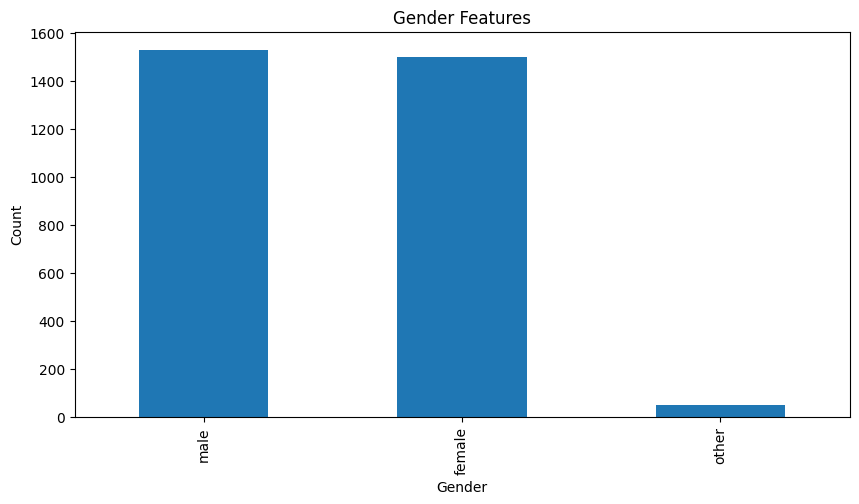

In [403]:
# drop unecesary columns
labels = labels.drop(columns=['client_id',
                              'up_votes', 
                              'down_votes', 
                              'accents', 
                              'locale', 
                              'segment', 
                              'variant', 
                              'sentence',])

# drop rows with missing values
labels = labels.dropna(subset=['gender'])
print(labels['gender'].value_counts())

# Create the bar plot
gender_feature_plot = labels['gender'].value_counts().plot(kind='bar', figsize=(10, 5))
gender_feature_plot.set_title('Gender Features')  # Set title for the plot
gender_feature_plot.set_xlabel('Gender')          # Set x-axis label
gender_feature_plot.set_ylabel('Count')           # Set y-axis label

# Filter the DataFrame to keep only rows where 'gender' is 'male' or 'female'
labels = labels[labels['gender'].isin(['male', 'female'])]

# replace the string values with integers
labels['gender'] = labels['gender'].replace({'male': 0, 'female': 1}).astype(int)


### Exports

In [404]:
# Save the figure
fig = gender_feature_plot.get_figure()
fig.savefig(IMAGE_PATH + 'gender_features.png', dpi=600, bbox_inches='tight', transparent=True)
table_to_latex(labels.head(), 'features')

## Signal Processing

### Audio output

In [405]:
# Update paths with the base directory path
paths = [os.path.join(AUDIO_PATH, path) for path in labels['path'].values]

# Load the audio file (example: first file in paths list)
audio_data, sample_rate = librosa.load(paths[1], sr=None)  # `sr=None` keeps the original sample rate
print(f"Number of samples: {len(audio_data)}, sample rate: {sample_rate}")
Audio(audio_data, rate=sample_rate)

Number of samples: 182016, sample rate: 32000


### Waveform

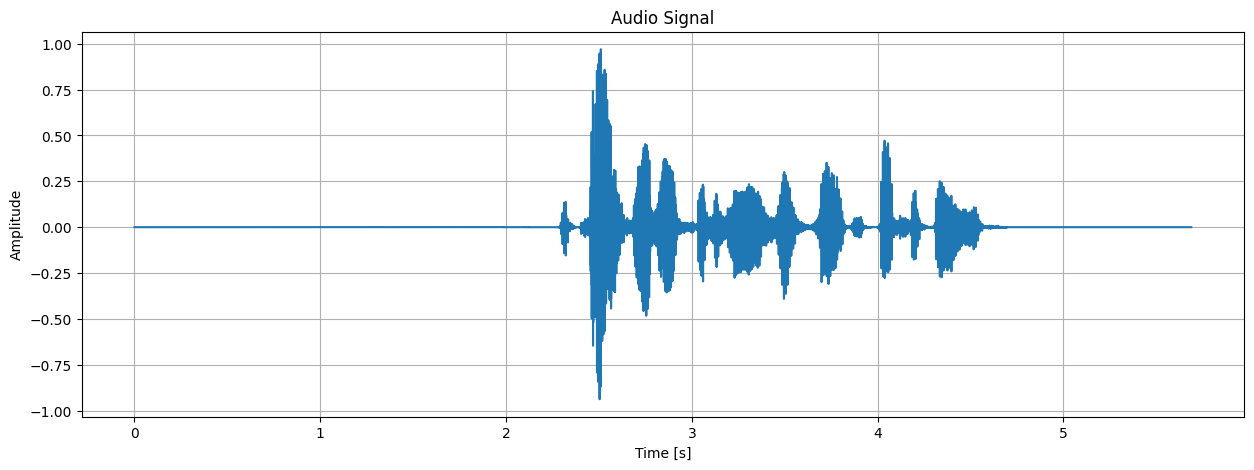

In [406]:
t = np.linspace(0, len(audio_data)/sample_rate, len(audio_data))
plt.figure(figsize=(15, 5))
plt.plot(t, audio_data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.grid()
plt.show()


### Spectrogram

In [407]:
N = 1024  # FFT window size
hop_length = 256  # Overlap between frames, adjust as needed
window = 'hann'  # Window type

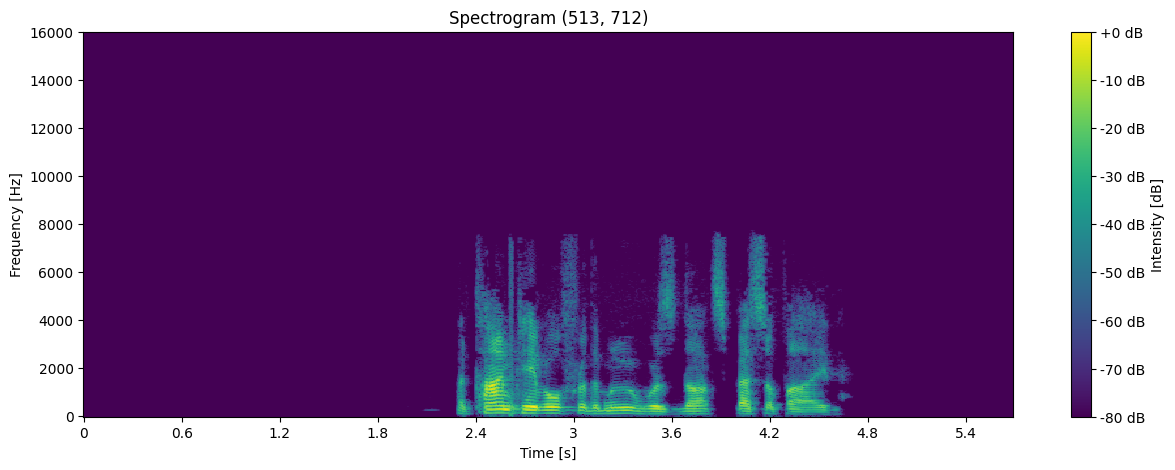

In [408]:
Sx = librosa.stft(audio_data, n_fft=N, hop_length=hop_length, window=window)    # Calculate STFT
Sx_dB = librosa.amplitude_to_db(abs(Sx), ref=np.max)    # spectrogram to dB scale

# Plot the spectrogram
title = f'Spectrogram {Sx_dB.shape}'
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [409]:
time_frames = (audio_data.shape[0])/hop_length + 1
time_frames
frequncy_bins = N//2 + 1
time_frames, frequncy_bins

(712.0, 513)

### Melspectrogram

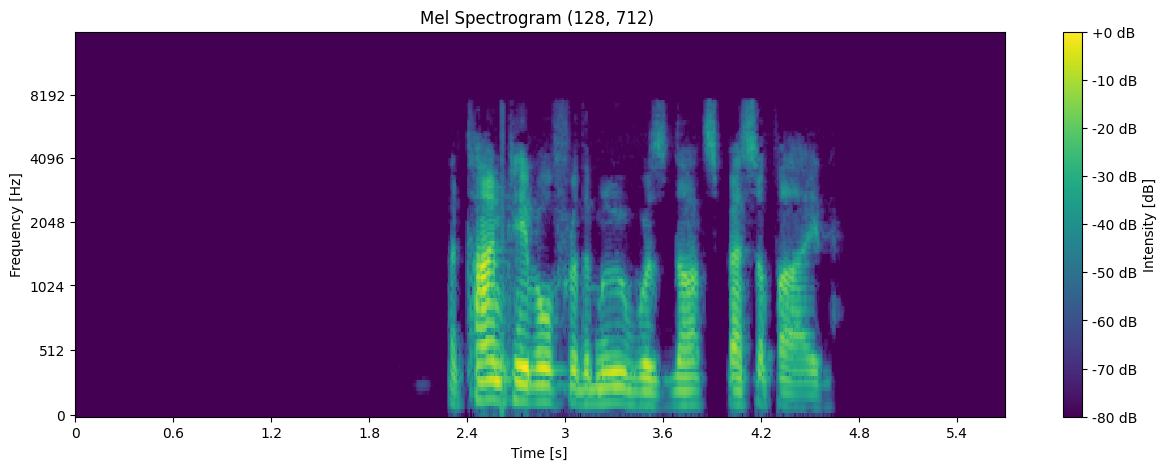

In [410]:
Sx_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=N, hop_length=hop_length)
Sx_mel_dB = librosa.power_to_db(Sx_mel, ref=np.max)

# Plot the mel spectrogram
title = f'Mel Spectrogram {Sx_mel_dB.shape} '
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(Sx_mel_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
ax.set_title(title)
fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Intensity [dB]')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
fig.savefig(IMAGE_PATH + title + '.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


## Deep Learning

In [411]:
def extract_mel_spectrogram(audio ,sr=22050, n_fft=1024, hop_length=512, n_mels=64,  target_shape=(64, 44)):
    # Convert to Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, 
                                                    sr=sr, 
                                                    n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels)
    
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)    # Convert to decibel scale (log scale)

    # # Resize the spectrogram to the target shape
    # mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
    # mel_spectrogram = F.interpolate(mel_spectrogram.unsqueeze(0).unsqueeze(0), size=target_shape).squeeze()
    return torch.tensor(mel_spectrogram, dtype=torch.float32)

### Dataset

In [412]:
class AudioDataset(Dataset):
    def __init__(self, audio_labels, audio_dir, transform=None, target_transform=None):
        self.labels = audio_labels
        self.dir = audio_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.dir, self.labels.iloc[idx, 0])
        audio, _ = librosa.load(audio_path, sr=None)
        spec = extract_mel_spectrogram(audio)

        label = self.labels.iloc[idx, 2]


        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # print(label)
        return spec, label

### Create Model

In [413]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        print(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [414]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Training

### Training and Validation Split

torch.Size([64, 244]) 0


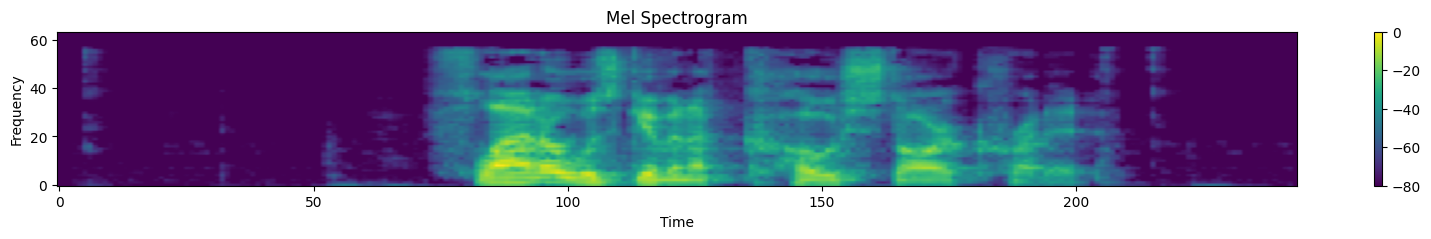

torch.Size([64, 356]) 0


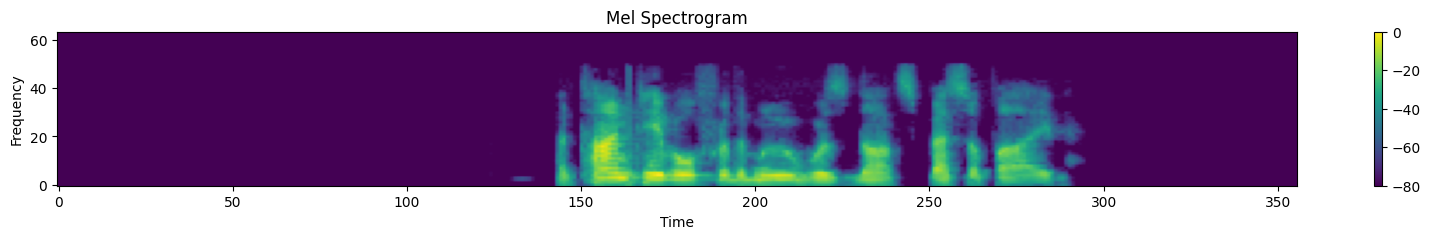

torch.Size([64, 199]) 1


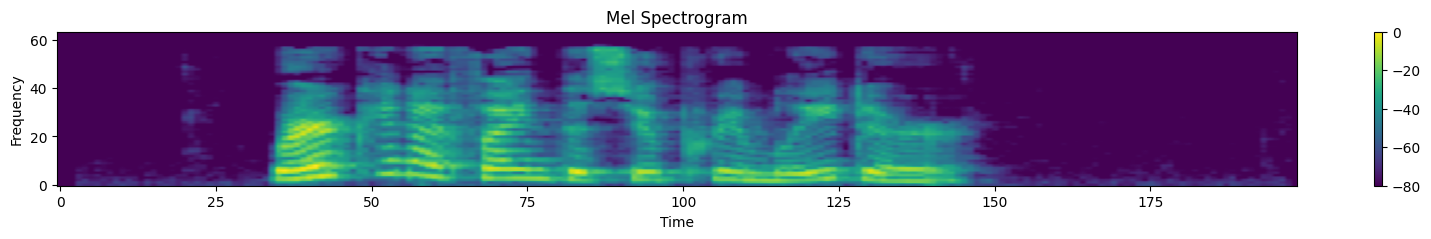

torch.Size([64, 275]) 0


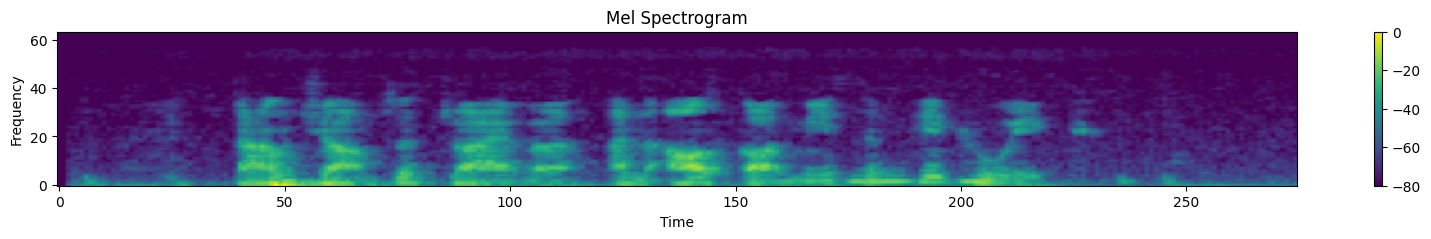

torch.Size([64, 451]) 0


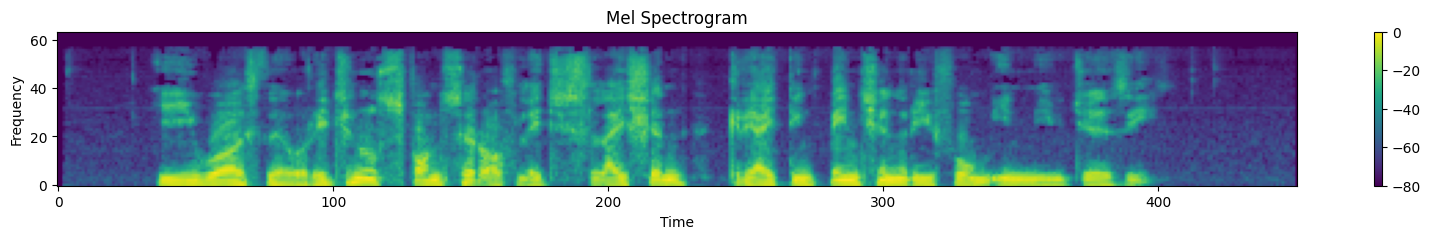

In [415]:
data = AudioDataset(labels, AUDIO_PATH)

for i in range(5):
    spec, label = data.__getitem__(i)
    print(spec.shape, label)
    plt.figure(figsize=(20, 2))
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()


train_loader = DataLoader(data, batch_size=64, shuffle=True)

### Loss function

In [416]:
loss_fn = nn.CrossEntropyLoss()

### Optimizer

In [417]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

### Training

In [418]:
def train_one_epoch(epoch_index, tb_writer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch {epoch_index}, batch {i+1}: loss {running_loss/100:.3f}")
            tb_writer.add_scalar('training loss', running_loss/100, epoch_index*len(train_loader) + i)
            running_loss = 0.0